In [35]:
import pandas as pd
import tushare as ts
from sqlalchemy import create_engine
import time
import datetime
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Dense,LSTM,Dropout,Conv1D,BatchNormalization
import math
from sklearn.metrics import mean_squared_error

In [36]:
# 设置参数
asset='I' # E股票 I沪深指数 C数字货币 FT期货 FD基金 O期权 CB可转债（v1.2.39），默认E
ts_code='000905.SH'
lookfwd=5
lookback=100
split=0.8
cutoff='20201031'

In [37]:
# 在线获取历史记录
def get_stock_history_remote(ts_code):
    with open('./parameters.json', 'r') as f:
        p = json.load(f)
        user = p['user']
        port = p['port']
        psw = p['password']
        host = p['host']
        token = p['TU_share_pro_taken']
        cnnstr = "mysql://" + user + ":" + psw + "@" + host + ":" + str(port) + "/stock?charset=utf8&use_unicode=1"
    engine_ts = create_engine(cnnstr)
    ts.set_token(token)
    df = ts.pro_bar(ts_code=ts_code, end_date=cutoff,
                            asset=asset, adj='qfq', freq='D')
    df=df[['trade_date','open','high','low','close','amount']]
    df.sort_values(by='trade_date',inplace=True)
    return df

In [110]:
df=get_stock_history_remote(ts_code)
df.head(5)

,trade_date,open,high,low,close,amount
3844,20050104,996.682,996.682,984.795,986.927,1329187.122
3843,20050105,986.570,1008.855,985.677,1003.633,1919861.791
3842,20050106,1003.490,1003.490,990.792,994.595,1629216.031
3841,20050107,993.434,1009.000,990.446,997.606,1906530.712
3840,20050110,996.928,1006.457,993.123,1006.337,1650218.869


In [111]:
df.drop(df[np.isnan(df['close'])].index, inplace=True) 

In [112]:
df.head(5)

,trade_date,open,high,low,close,amount
3844,20050104,996.682,996.682,984.795,986.927,1329187.122
3843,20050105,986.570,1008.855,985.677,1003.633,1919861.791
3842,20050106,1003.490,1003.490,990.792,994.595,1629216.031
3841,20050107,993.434,1009.000,990.446,997.606,1906530.712
3840,20050110,996.928,1006.457,993.123,1006.337,1650218.869


In [113]:
# 计算未来5日的涨跌幅度分类
flag=[]
for i in range(0,len(df)-lookfwd):
    close=df.iloc[i,4]
    ndays=df.iloc[i+1:i+1+lookfwd,4]
    avg_price=np.mean(ndays)
    compare=(avg_price-close)/close
    if compare >=0.5:
        flag.append(1)
#     elif compare >=0.05:
#         flag.append(1)
    elif compare >=0.02 and compare<0.05:
        flag.append(0)
    else:
        flag.append(-1)
df.drop(df.tail(lookfwd).index,inplace=True)    

df['flag']=flag
df.tail(20)

,trade_date,open,high,low,close,amount,flag
24,20200918,6367.7923,6473.5997,6353.5609,6469.4692,136788919.9,-1
23,20200921,6492.2249,6515.3370,6434.3239,6445.9649,133640323.5,-1
22,20200922,6392.0250,6462.9751,6341.4838,6358.6520,122989741.8,-1
21,20200923,6382.2813,6411.2048,6356.1636,6392.0329,106027143.4,-1
20,20200924,6353.6940,6354.6827,6243.2820,6244.6389,112624608.4,-1
19,20200925,6271.7008,6285.4717,6206.1823,6236.8904,92989168.4,-1
18,20200928,6255.0210,6261.9304,6171.0200,6178.4693,87526269.8,0
17,20200929,6206.9908,6280.4433,6179.8807,6228.7708,91783259.9,0
16,20200930,6245.1158,6260.1234,6155.0208,6192.5045,89615460.4,0
15,20201009,6300.0703,6373.9367,6290.4705,6357.9711,115149926.3,0


In [ ]:
# 计算收盘价未来n天的平均价格
# moving_ndays_close=[]
# for i in range(0,len(df)-lookfwd):
#     ndays=df.iloc[i+lookfwd,4]
#     moving_ndays_close.append(ndays)
# df.drop(df.tail(lookfwd).index,inplace=True)    
# # moving_ndays_close=moving_ndays_close+list(np.zeros(lookfwd))  # 直接用收盘价来不足最后5天的移动平均价格
# df['moving_ndays_close']=moving_ndays_close
# df.tail(10)

In [114]:
df.drop(['trade_date'],axis=1,inplace=True)
df.tail(5)

,open,high,low,close,amount,flag
9,6466.5660,6483.5079,6346.2632,6358.3213,114682882.3,-1
8,6349.6437,6423.1573,6324.3889,6423.1128,95327322.7,-1
7,6426.1940,6426.5095,6323.4406,6350.0127,102120928.5,-1
6,6331.8037,6334.5424,6256.2324,6317.1438,96745752.1,-1
5,6312.0076,6362.4283,6202.5347,6213.2626,93954361.2,-1


In [115]:
# 划分训练集、测试集
def data_split(data,split):
    train_size = int(len(data)*split)
    test_size = len(data)-train_size
    train_data = data.iloc[0:train_size,:]
    test_data = data.iloc[train_size:len(data),:]
    return(train_data,test_data)

train_data,test_data=data_split(df,split)

In [116]:
# 将数据转成0-1之间
scaler= MinMaxScaler(feature_range=(0,1))
train_data = scaler.fit_transform(train_data)  # 注意一定要用训练集来创建scaler. 这一步是fit 和 transform一步到位。注意fit一定是针对训练集来做的

In [117]:
scaler.data_max_,scaler.data_min_,

(array([1.15899517e+04, 1.16163848e+04, 1.14006514e+04, 1.15458906e+04,
        4.84525592e+08, 0.00000000e+00]),
 array([ 6.95767000e+02,  7.05076000e+02,  6.92697000e+02,  6.96848000e+02,
         1.32918712e+06, -1.00000000e+00]))

In [118]:
test_data = scaler.transform(test_data)  # 将测试集归一, 这里一定不能再次fit了，直接用transform即可

In [119]:
train_data.shape,test_data.shape

((3072, 6), (768, 6))

In [104]:
# 构建函数来预处理数据,移动数据框
def create_dataset(dataset, lookback):
    X,Y=[],[]
    for i in range(lookback,len(dataset)):
        a=dataset[(i-lookback):i,0:-1] # 0-99 行  所有列
        b=dataset[i,-1]# 100行 最后一列
        X.append(a)      
        Y.append(b) 
    return np.array(X), np.array(Y)

In [105]:
x_train,y_train = create_dataset(train_data,lookback=lookback)
x_test,y_test = create_dataset(test_data,lookback=lookback)
x_train.shape,y_train.shape

((2972, 100, 5), (2972,))

In [106]:
#搭建模型
# model = Sequential()
# model.add(LSTM(32, input_shape=(x_train.shape[1],x_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(16, return_sequences=False))
# # model.add(Dropout(0.2))
# # model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
# # model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
# model.add(Dense(1))
# # model = load_model('my_LSTM_stock_model1000.h5')
# # adam = keras.optimizers.Adam(decay=0.2)

In [ ]:
# 搭建模型2
model = Sequential()
model.add(Conv)

In [107]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam')

In [108]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 32)           4864      
_________________________________________________________________
dropout_4 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 8,017
Trainable params: 8,017
Non-trainable params: 0
_________________________________________________________________


In [109]:
# 训练数据
history=model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100


InvalidArgumentError:  Received a label value of 1 which is outside the valid range of [0, 1).  Label values: 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1
	 [[node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-109-d2de1024c360>:2) ]] [Op:__inference_train_function_57631]

Function call stack:
train_function


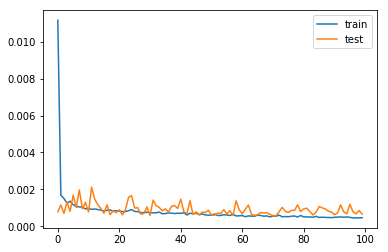

In [54]:
# 查看模型收敛状况
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

In [ ]:
# 评价模型质量
# def model_score(model,x_train,y_train,x_test,y_test):
#     trainScore = model.evaluate(x_train, y_train, verbose=0)
#     print('Train Score: %s MSE (%s RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))
#     testScore = model.evaluate(x_test, y_test, verbose=0)
#     print('Test Score: %s MSE (%s RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    
# model_score(model, x_train, y_train, x_test, y_test)

In [ ]:
# model.save('trained_model_stock_lstm_multiple_elements_%s' % ts_code)

In [59]:
# 从硬盘取出模型
# l = models.load_model('trained_model_stock_lstm_multiple_elements_%s' % ts_code)

In [ ]:
# test_predict_l=l.predict(x_test)
# test_predict=model.predict(x_test)
# test_predict == test_predict_l

In [55]:
# 预测数据
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)
train_predict.shape,test_predict.shape

((2972, 1), (668, 1))

In [56]:
# 将结果组合成归一化之前的结构 方便后面还原数据
zero_train=np.zeros((train_predict.shape[0],train_data.shape[1]-1)) 
zero_test=np.zeros((test_predict.shape[0],train_data.shape[1]-1))
# 合并列，注意预测值放在最后列，因为当初归一化的时候y值就最后
train_predict=np.column_stack((zero_train,train_predict)) 
test_predict=np.column_stack((zero_test,test_predict))
train_predict.shape,test_predict.shape

((2972, 6), (668, 6))

In [57]:
# 数据还原
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
train_predict

array([[6.95767000e+02, 7.05076000e+02, 6.92697000e+02, 6.96848000e+02,
        1.32918712e+06, 8.40071407e+02],
       [6.95767000e+02, 7.05076000e+02, 6.92697000e+02, 6.96848000e+02,
        1.32918712e+06, 8.65295130e+02],
       [6.95767000e+02, 7.05076000e+02, 6.92697000e+02, 6.96848000e+02,
        1.32918712e+06, 8.82404931e+02],
       ...,
       [6.95767000e+02, 7.05076000e+02, 6.92697000e+02, 6.96848000e+02,
        1.32918712e+06, 6.39045210e+03],
       [6.95767000e+02, 7.05076000e+02, 6.92697000e+02, 6.96848000e+02,
        1.32918712e+06, 6.39940631e+03],
       [6.95767000e+02, 7.05076000e+02, 6.92697000e+02, 6.96848000e+02,
        1.32918712e+06, 6.42244010e+03]])

In [58]:
print(train_predict[:,-1])

[ 840.07140663  865.29513017  882.40493064 ... 6390.4520972  6399.40630587
 6422.44009749]


In [59]:
# 计算还原后结果准确度标准差及变异系数。
train_rmse= math.sqrt(mean_squared_error(y_train,train_predict[:,-1]))
test_rmse=math.sqrt(mean_squared_error(y_test,test_predict[:,-1]))
avg=np.mean(list(df['moving_ndays_close'][-test_predict.shape[0]:]))
test_cv=test_rmse/avg
train_rmse,test_rmse,test_cv

(4523.095471656702, 5473.084593434189, 1.0273777542998406)

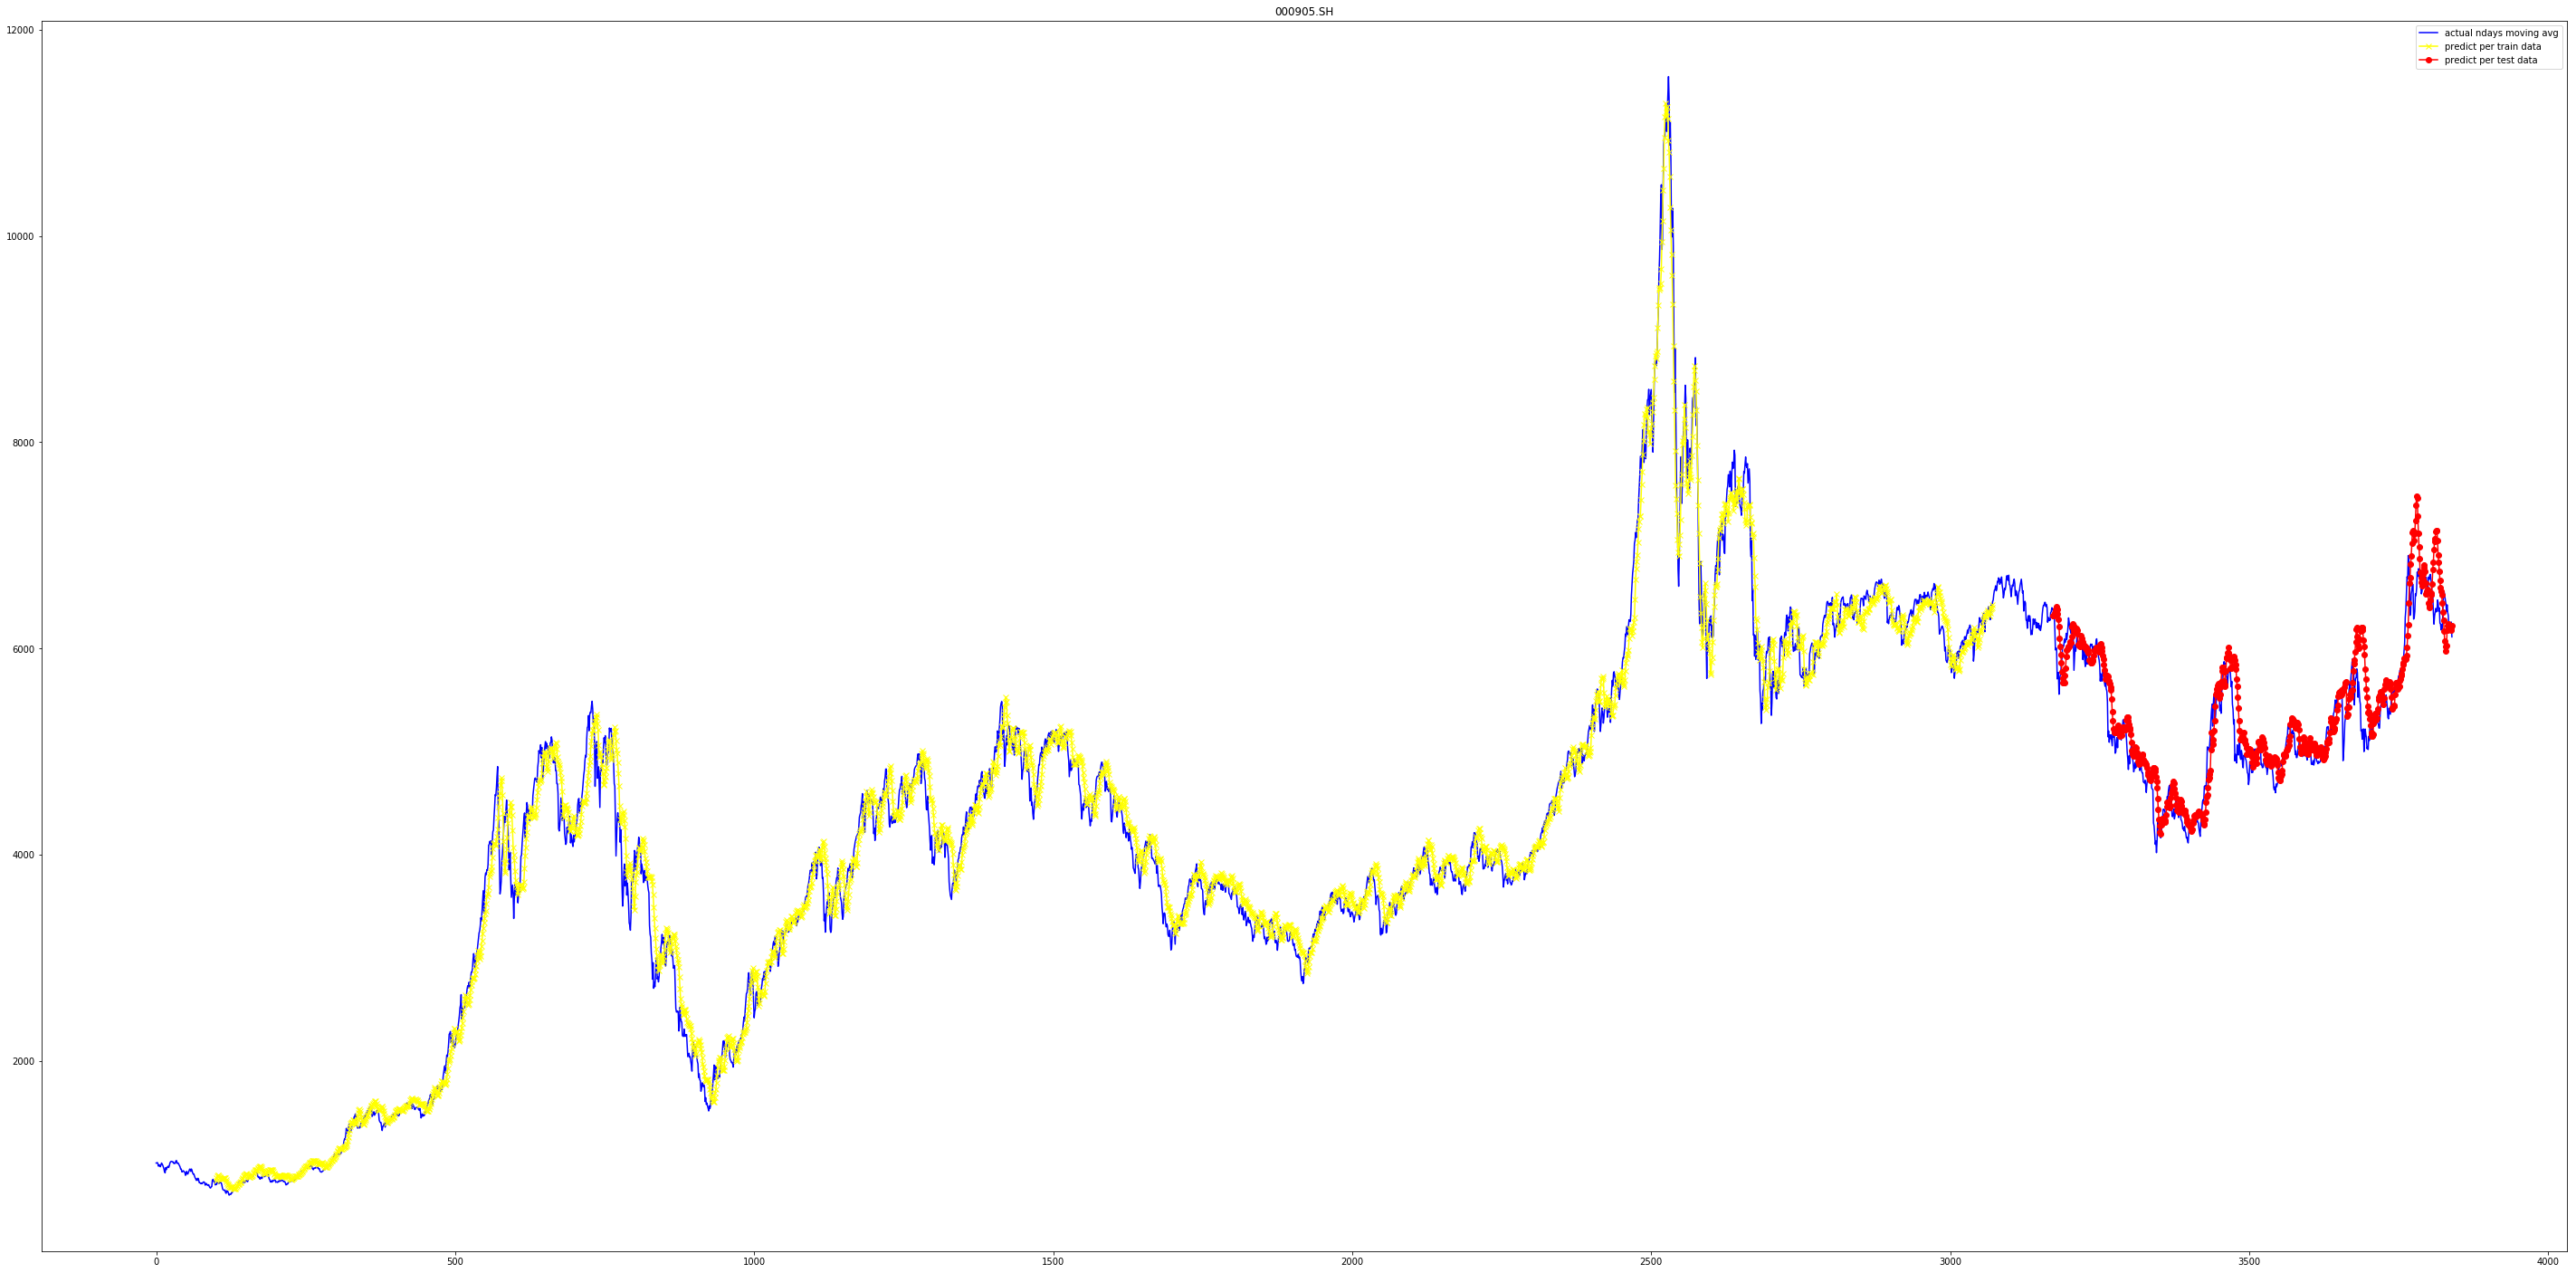

In [60]:
# 绘制计算结果图
trainPredictPlot=np.empty_like(df['moving_ndays_close'])
trainPredictPlot[:]=np.nan

trainPredictPlot[lookback:len(train_predict)+lookback]=train_predict[:,-1]

test_start_point=len(train_predict)+lookback*2 
testPredictPlot=np.empty_like(df['moving_ndays_close'])
testPredictPlot[:]=np.nan
# 测试值赋给一个列表，位置整体往后移动100*2
testPredictPlot[test_start_point:]=test_predict[:,-1]
plt.figure(figsize=(50,25))
# plt.plot(list(df['close']),c='blue',label="close data")
# plt.plot(list(df['close']),c='black',label="price")
plt.plot(list(df['moving_ndays_close']),c='blue',label="actual ndays moving avg")
plt.plot(trainPredictPlot,c='yellow',marker="x",label="predict per train data")
plt.plot(testPredictPlot,c='red',marker="o",label="predict per test data")
plt.title(ts_code)
plt.legend()
plt.show()

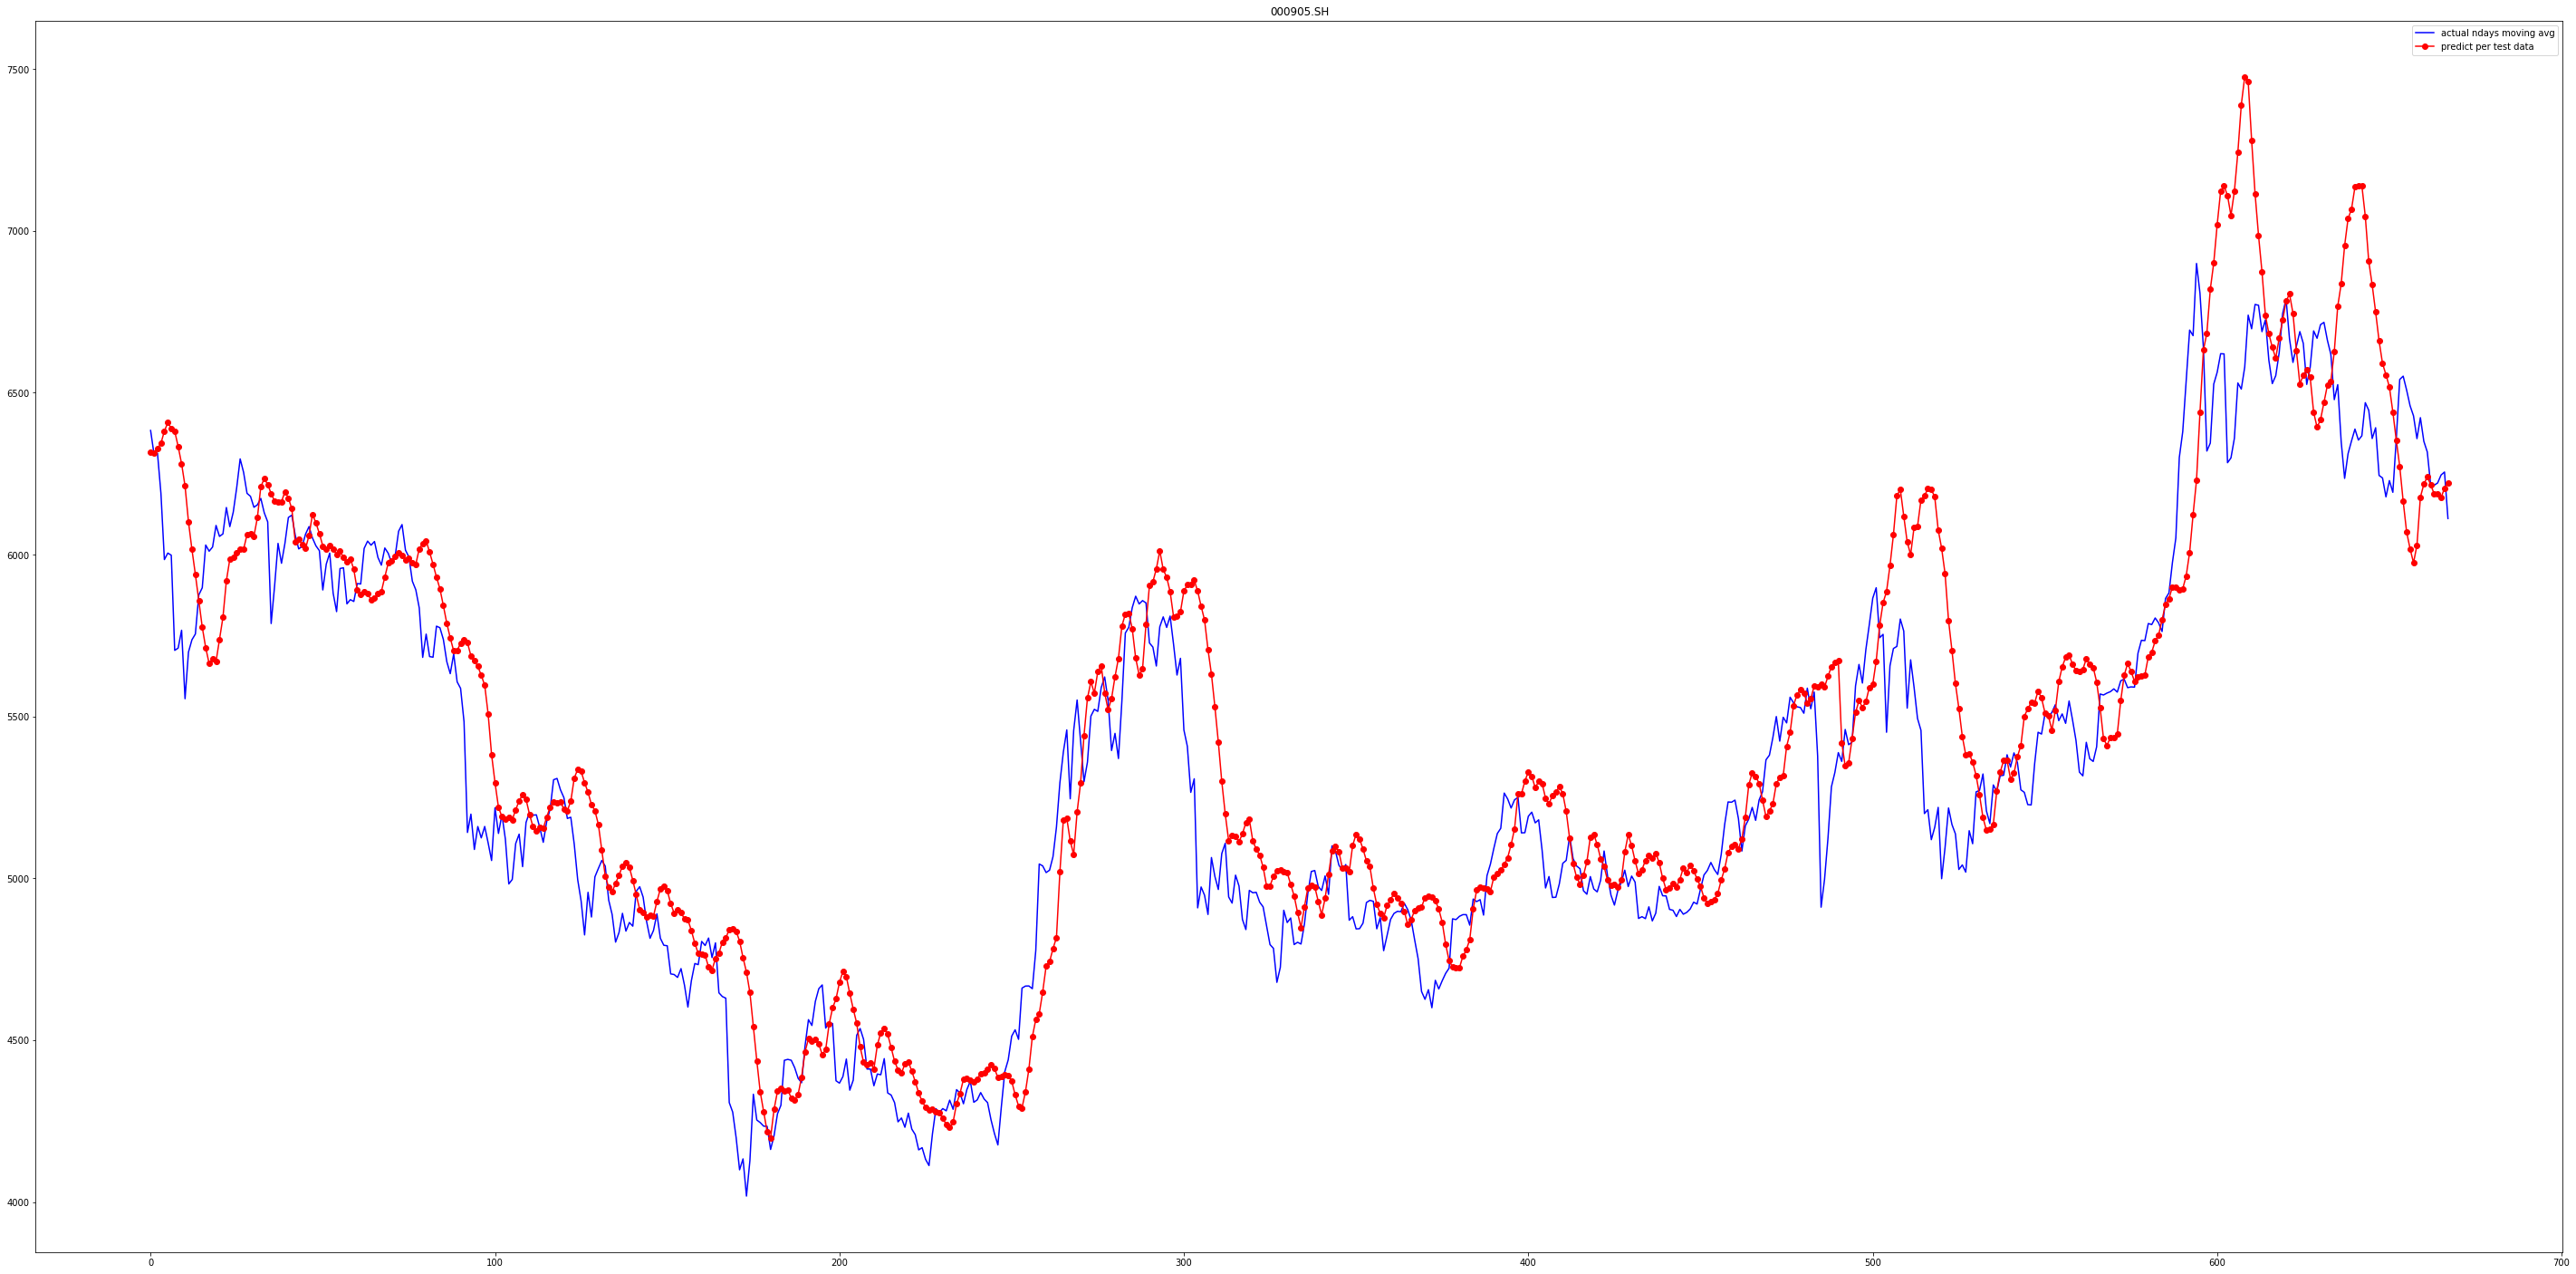

In [61]:
# 绘制测试集结果
plt.figure(figsize=(50,25))
plt.plot(list(df['moving_ndays_close'][-test_predict.shape[0]:]),c='blue',label="actual ndays moving avg")
plt.plot(test_predict[:,-1],c='red',marker="o",label="predict per test data")
plt.title(ts_code)
plt.legend()
plt.show()

In [62]:
def result_difference(test_predict, real_price):
    test_predict=np.array(test_predict)
    real_price=np.array(real_price)
    diff=[]
    for i in range(len(test_predict)):
        predit_price=round(test_predict[i],2)
        actual_price=round(real_price[i],2)
        price_diff=round(predit_price-actual_price,2)
        percentage_diff=round((predit_price-actual_price)/actual_price,2)
        diff.append([predit_price,actual_price,price_diff,percentage_diff])
    return np.array(diff)
p = result_difference(test_predict[:,-1], df['moving_ndays_close'][-test_predict.shape[0]:])
p

array([[ 6.31794e+03,  6.38363e+03, -6.56900e+01, -1.00000e-02],
       [ 6.31486e+03,  6.30988e+03,  4.98000e+00,  0.00000e+00],
       [ 6.32760e+03,  6.31344e+03,  1.41600e+01,  0.00000e+00],
       ...,
       [ 6.17656e+03,  6.24600e+03, -6.94400e+01, -1.00000e-02],
       [ 6.20493e+03,  6.25519e+03, -5.02600e+01, -1.00000e-02],
       [ 6.22197e+03,  6.11148e+03,  1.10490e+02,  2.00000e-02]])

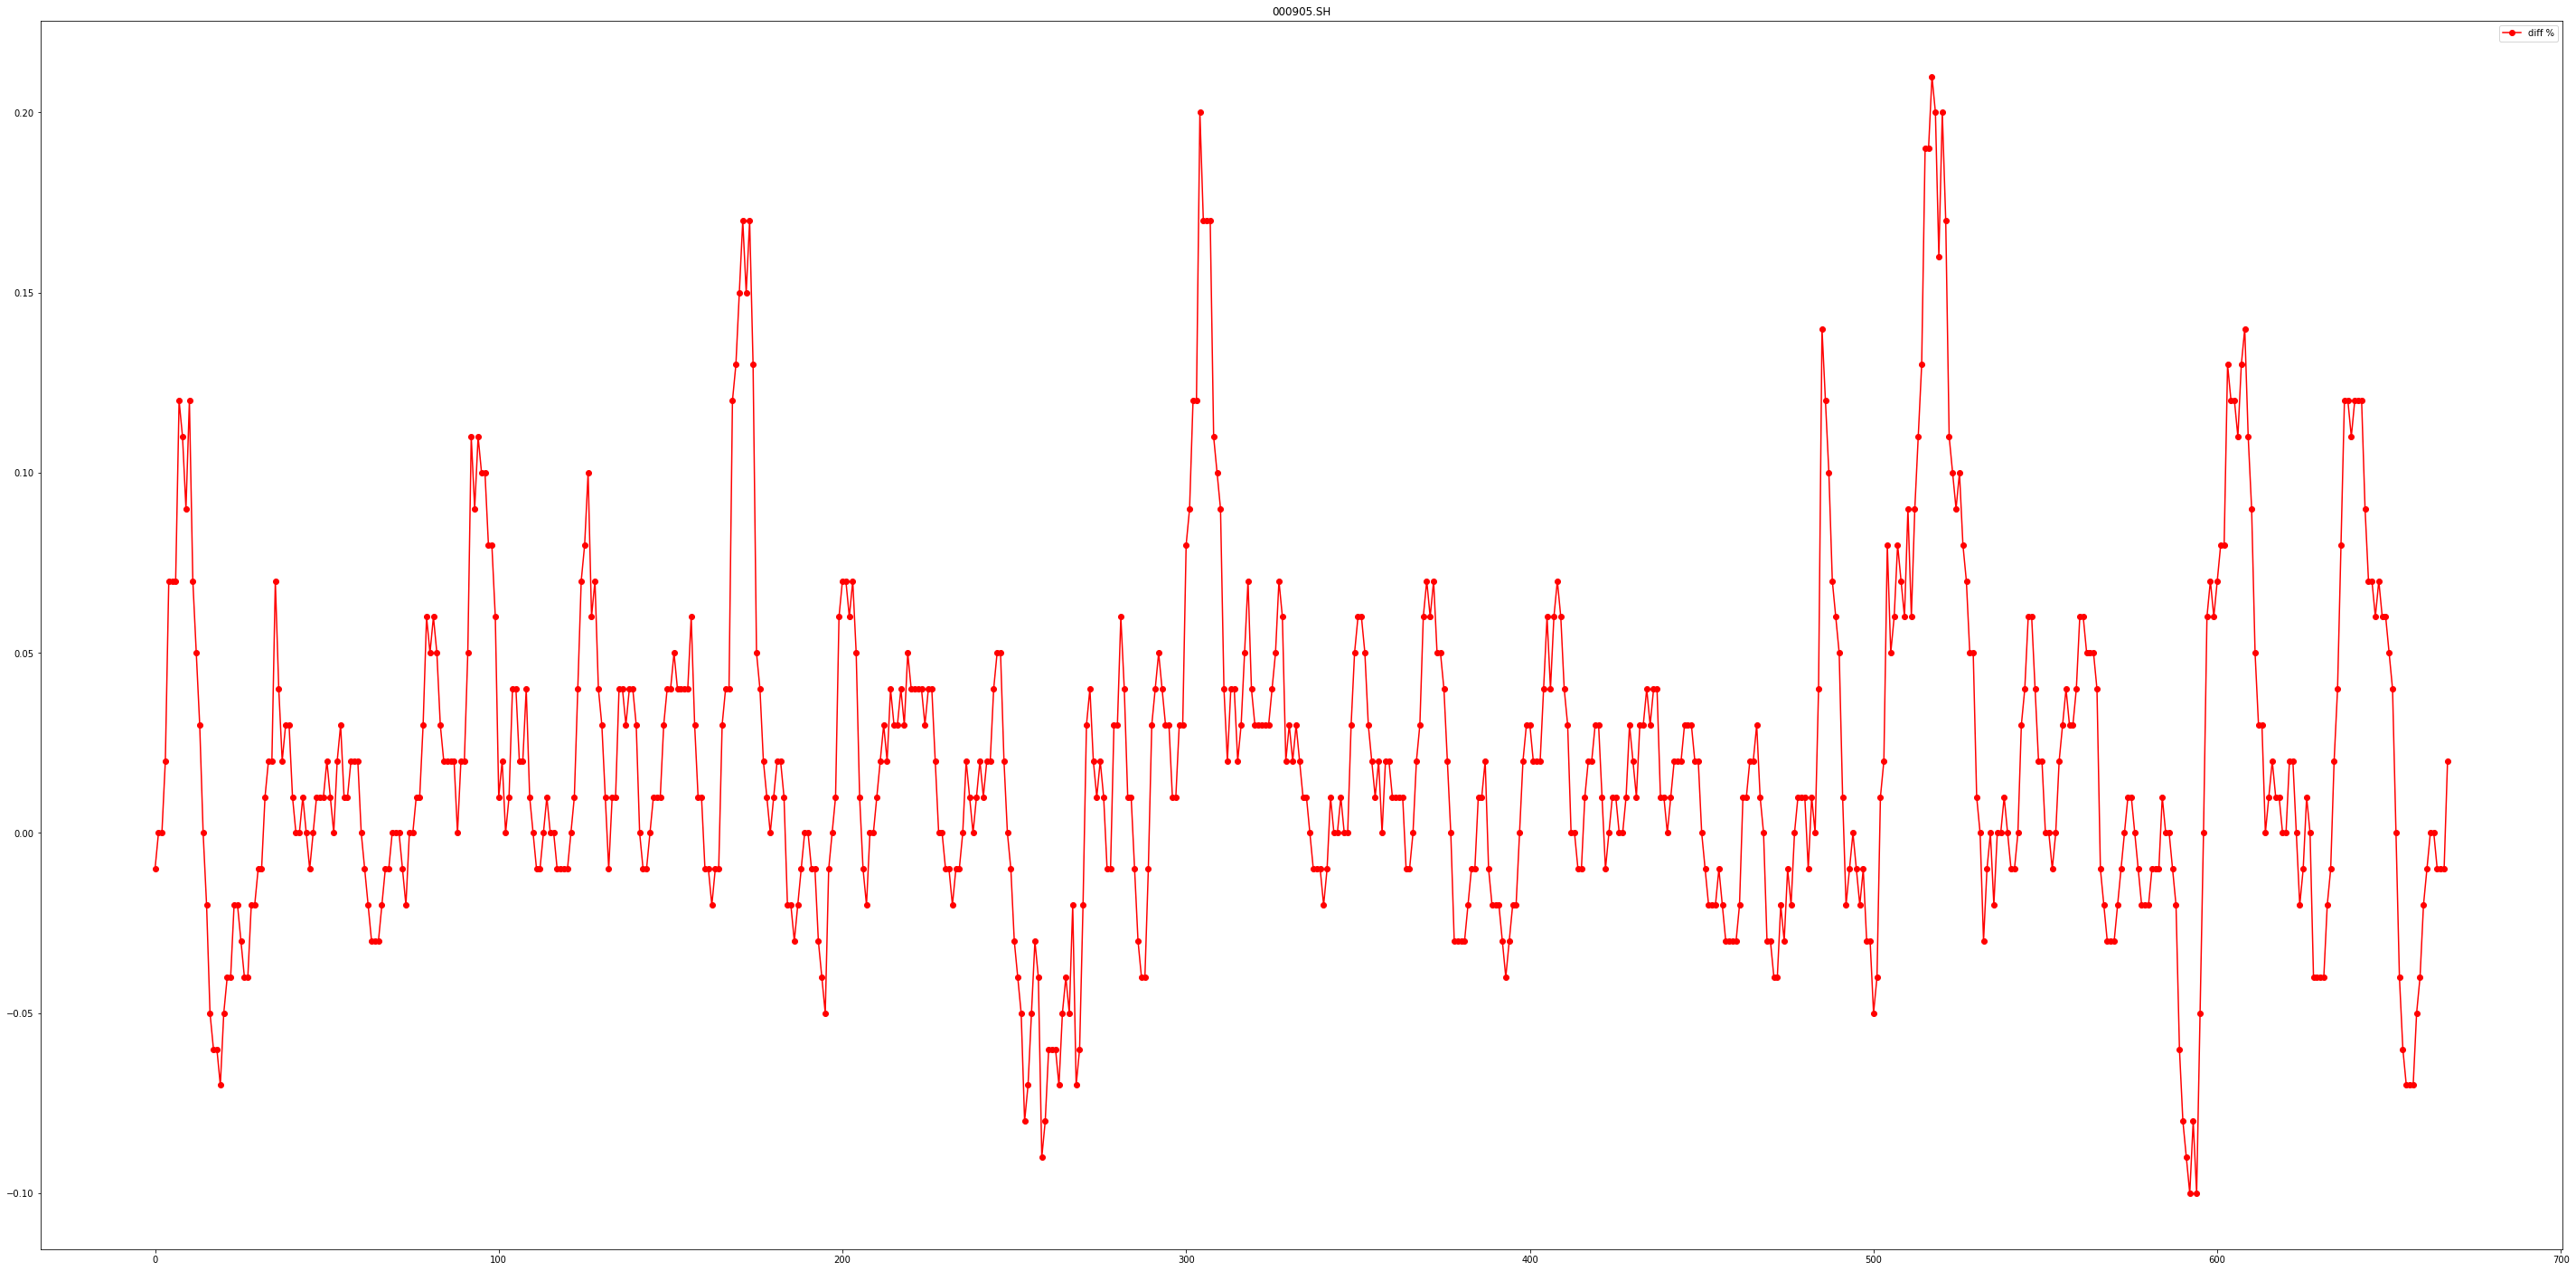

In [63]:
plt.figure(figsize=(50,25))
plt.plot(p[:,-1],c='red',marker="o",label="diff %")
plt.title(ts_code)
plt.legend()
plt.show()